# Digit recognition - multiclass classification


## 1.1 Reading collected and MNIST datasets
  
  


In [30]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from skimage.filters import threshold_otsu
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape
from keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Resizing

seed = 173
np.random.seed(seed)

In [2]:
df = pd.read_csv("data/drawings.csv")
mnist = pd.read_csv("data/train.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [3]:
def binarize_mnist(image_collection):
    """
    Inverts a collection of images and makes it binary
    """

    imges = []

    for img in image_collection:
        # Retrieve an Otsu threshold for the image
        thresh = threshold_otsu(img)
        # Which pixels are beyond the threshold
        binary = img > thresh
        # Flatten
        imges.append(binary.reshape(28*28))

    return imges

# Pass the mnist dataframe into the binarizer and craft a dataframe
mnistBin = pd.DataFrame(binarize_mnist(np.array(mnist.iloc[:,1:]).reshape(len(mnist), 28, 28)))

In [4]:
# attach the appropriate label to each observation
mnistBin["label"] = mnist.label
# convert columns from bool to int
mnistBin = mnistBin + 0
mnistBin

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [5]:
# join the mnist and custom datasets, shuffle
jointDf = pd.DataFrame(np.concatenate([np.array(df), np.array(mnistBin)]))\
    .sample(frac=1, random_state=seed)\
        .reset_index(drop=True)\
            .rename({784: "label"}, axis=1)

In [6]:
jointDf

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
47514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
47515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Class balance

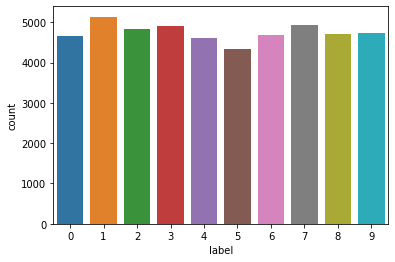

In [7]:
sns.countplot(x = jointDf.label);

#### Training and hold-out sets

In [8]:
y = to_categorical(jointDf.label)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(jointDf.iloc[:,:-1], y, train_size=0.9, random_state=seed) # no need to stratify for large balanced datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42765, 784), (4752, 784), (42765, 10), (4752, 10))

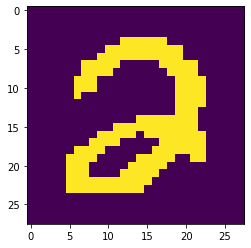

In [10]:
plt.imshow(np.array(x_test.sample(1, random_state=seed)).reshape(28, 28));

In [48]:
def get_model(seed):
        model = Sequential([
                # Preprocessing
                Reshape((28, 28, 1), input_shape=(1, 28*28)),
                RandomRotation(0.12, seed=seed, fill_mode="constant", fill_value=0),
                RandomHeight(0.13, seed=seed, interpolation="bicubic"),
                RandomWidth(0.13, seed=seed, interpolation="bicubic"),
                RandomTranslation(0.16, 0.14, seed=seed, fill_mode="constant", fill_value=0),
                Resizing(28, 28, interpolation="bicubic"),


                # Subsampling-Convolution triplet 1
                Conv2D(32, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(32, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(32, kernel_size=5, padding="same", activation="relu", strides=2),
                BatchNormalization(axis=1),
                Dropout(0.35, seed=seed),


                # Subsampling-Convolution triplet 2
                Conv2D(64, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(64, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(64, kernel_size=5, padding="same", activation="relu", strides=2),
                BatchNormalization(axis=1),
                Dropout(0.35, seed=seed),

                # Decision-making
                Flatten(),
                Dense(256, activation="relu"),
                Dropout(0.35),
                Dense(24, activation="sigmoid"),
                Dense(10, activation="softmax")])
        
        opt = RMSprop(learning_rate = 0.001, decay = 0)
        model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])

        return model

lr_cut = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2, verbose=1, min_lr=0.0000001, mode="max", cooldown=1)
quicksave = ModelCheckpoint(monitor="val_accuracy", filepath="data/checkpoint.hdf5", verbose=1)

model = get_model(seed)
model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
random_rotation_17 (RandomRo (None, 28, 28, 1)         0         
_________________________________________________________________
random_height_15 (RandomHeig (None, None, 28, 1)       0         
_________________________________________________________________
random_width_13 (RandomWidth (None, None, None, 1)     0         
_________________________________________________________________
random_translation_12 (Rando (None, None, None, 1)     0         
_________________________________________________________________
resizing_10 (Resizing)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 26, 26, 32)      

In [49]:
hist = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data = (x_test, y_test), shuffle=False, callbacks=[lr_cut, quicksave])

Epoch 1/15
669/669 [==============================] - 279s 414ms/step - loss: 0.8682 - accuracy: 0.7653 - val_loss: 0.2279 - val_accuracy: 0.9465

Epoch 00001: saving model to data\checkpoint.hdf5
Epoch 2/15
669/669 [==============================] - 287s 429ms/step - loss: 0.2696 - accuracy: 0.9270 - val_loss: 0.1117 - val_accuracy: 0.9729

Epoch 00002: saving model to data\checkpoint.hdf5
Epoch 3/15
669/669 [==============================] - 248s 370ms/step - loss: 0.1987 - accuracy: 0.9448 - val_loss: 0.1672 - val_accuracy: 0.9543

Epoch 00003: saving model to data\checkpoint.hdf5
Epoch 4/15
669/669 [==============================] - 252s 376ms/step - loss: 0.1726 - accuracy: 0.9528 - val_loss: 0.0836 - val_accuracy: 0.9790

Epoch 00004: saving model to data\checkpoint.hdf5
Epoch 5/15
669/669 [==============================] - 253s 378ms/step - loss: 0.1553 - accuracy: 0.9576 - val_loss: 0.1046 - val_accuracy: 0.9737

Epoch 00005: saving model to data\checkpoint.hdf5
Epoch 6/15
669/

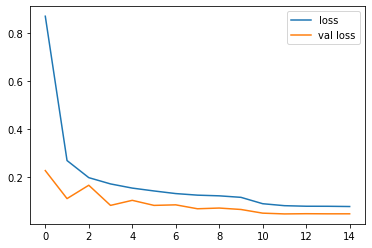

In [50]:
plt.plot(hist.history["loss"]);
plt.plot(hist.history["val_loss"]);
plt.legend(["loss", "val loss"]);

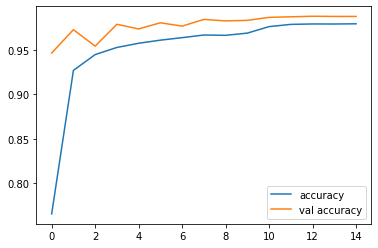

In [51]:
plt.plot(hist.history["accuracy"]);
plt.plot(hist.history["val_accuracy"]);
plt.legend(["accuracy", "val accuracy"]);